# Truncated Gaussians examples

It is well known that the normal / Gaussian distribution is the distribution with maximum entropy subject to constraints on the first two moments. In this example we show the shapes of some distributions that arise when we place a bounds constraint in addition to constraints on the first two moments.

In [1]:
from scipy import stats
import scipy.sparse
import numpy as np
import pandas as pd

import maxentropy

In [2]:
def f0(x):
    return x

In [3]:
def f1(x):
    return x**2

In [4]:
def f2(x):
    return (lower < x) & (x < upper)

In [5]:
features = [f0, f1, f2]

### Example 1: $E(X)=0, E(X^2)=1, P(-2.5<X<2.5)=1$

In [6]:
# Bounds and target expectations
lower, upper = (-2.5, 2.5)
target_expectations = [0, 1, 1]      # E(X) = 0, E(X^2)=1, P(lower<x<upper)=1

Create a generator of features of random points under a Gaussian auxiliary dist $q$ with the same mean and twice the standard deviation:

In [7]:
mu = target_expectations[0]
sigma = (target_expectations[1] - mu**2)**0.5
mu, sigma

(0, 1.0)

In [8]:
from maxentropy.utils import auxiliary_sampler_scipy

We create `auxiliary_sampler` as a generator function that will be used for importance sampling. This yields a tuple `(sample_xs, log_q_xs)` whose dimensions are `(d, n)` and `(n,)`.

In [9]:
sampler = auxiliary_sampler_scipy(stats.uniform(loc=mu-4*sigma, scale=8*sigma), n=10**5)

In [10]:
sample_xs, log_q_xs = sampler()

In [11]:
sample_xs.shape, log_q_xs.shape

((100000, 1), (100000,))

In [12]:
import matplotlib.pyplot as plt

plt.hist(sample_xs, density=True);

We pass `features` as a single vectorized function that returns a matrix or list of (preferably) vectorized functions that each operate on each vector of samples xs = `[x_1,...,x_n]`.

In [13]:
features

[<function __main__.f0(x)>,
 <function __main__.f1(x)>,
 <function __main__.f2(x)>]

In [14]:
# Create a model
model = maxentropy.skmaxent.MCMinDivergenceModel(features, sampler,
                                                 vectorized=False)   

In [15]:
X = np.reshape(target_expectations, (1, -1))
X.shape

(1, 3)

In [16]:
target_expectations

[0, 1, 1]

In [17]:
model.expectations()  # before fitting

array([-0.00625577,  5.33408217,  0.62537   ])

In [18]:
model.features(sample_xs).A[:, :5]

array([[ 2.90555798, -3.90771517, -3.82005595,  3.6764488 , -0.51516949],
       [ 8.44226715, 15.27023781, 14.59282747, 13.51627581,  0.26539961],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  1.        ]])

In [19]:
model.fit(X)

MCMinDivergenceModel(algorithm='CG',
                     auxiliary_sampler=<function auxiliary_sampler_scipy.<locals>.sampler at 0x1a202f9ae8>,
                     feature_functions=None, matrix_format='csc_matrix',
                     prior_log_pdf=None, vectorized=None, verbose=0)

In [20]:
model.expectations()

array([-6.44591416e-08,  9.99999980e-01,  9.99999997e-01])

In [21]:
np.abs(X - model.expectations())

array([[6.44591416e-08, 2.03714793e-08, 3.00377911e-09]])

In [22]:
np.allclose(model.expectations(), X, atol=1e-7)

True

In [23]:
model.iters, model.fnevals

(77, 286)

After running this code, the `model` has a vector
of parameters $\theta = (\theta_i)^{3}_{i=1}$
stored as the array `model.params`. The pdf of the fitted model can then be retrieved
with the `model.pdf` method and plotted as follows:



In [24]:
%matplotlib inline

In [25]:
lower, upper

(-2.5, 2.5)

In [26]:
# Plot the pdf:
x = np.linspace(lower, upper, num=1000)
# all_xs = np.zeros((len(x), 1), float)
# all_xs[:, 0] = xs

In [27]:
# all_xs.shape
# (1000, 1)

In [28]:
model.features(x)

<3x1000 sparse matrix of type '<class 'numpy.float64'>'
	with 2998 stored elements in Compressed Sparse Column format>

In [29]:
pdf = model.pdf(model.features(x))

(0, 0.4192514786443419)

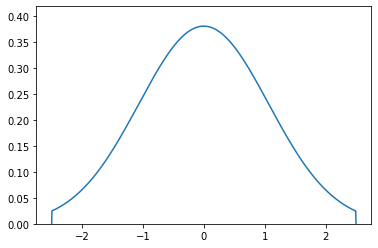

In [30]:
plt.plot(x, pdf)
plt.ylim(0, pdf.max()*1.1)

### Example 2: $E(X)=1.0, E(X^2)=1.2, P(0.5<X<2.5)=1$

In [31]:
lower, upper = (0.5, 2.5)
target_expectations = [1.0, 1.2, 1]  # E(X) = 1, E(X^2)=1.2, P(lower<x<upper)=1

In [32]:
X = np.reshape(target_expectations, (1, -1))
X.shape

(1, 3)

In [33]:
model.fit(X)

MCMinDivergenceModel(algorithm='CG',
                     auxiliary_sampler=<function auxiliary_sampler_scipy.<locals>.sampler at 0x1a202f9ae8>,
                     feature_functions=None, matrix_format='csc_matrix',
                     prior_log_pdf=None, vectorized=None, verbose=0)

In [34]:
pdf = model.pdf(model.features(x))

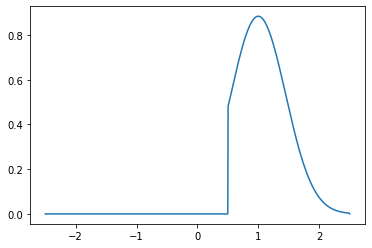

In [35]:
import matplotlib.pyplot as plt
plt.plot(x, pdf)

## Example 3: Forbes data

Here we take an example of constraining the probabilities in given regions with real data: statistics of the Forbes 2000 companies. We create a model for market value that cannot be negative.

In [36]:
import pandas as pd
forbes = pd.read_csv('https://github.com/PythonCharmers/PythonCharmersData/raw/master/forbes1964.csv')

In [37]:
forbes[:5]

,rank,name,country,sales,profits,assets,marketvalue
0,1,Citigroup,United States,94.71,17.85,1264.03,255.30
1,2,General Electric,United States,134.19,15.59,626.93,328.54
2,3,American Intl Group,United States,76.66,6.46,647.66,194.87
3,4,ExxonMobil,United States,222.88,20.96,166.99,277.02
4,5,BP,United Kingdom,232.57,10.27,177.57,173.54


In [94]:
mv = forbes['marketvalue'].dropna()

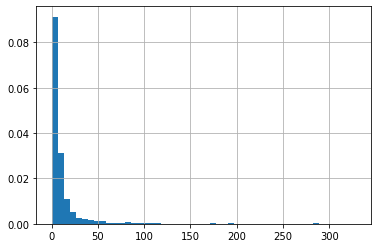

In [95]:
mv.hist(bins=50, density=True)

In [96]:
mv.describe()

count    1966.000000
mean       11.735549
std        24.302136
min         0.020000
25%         2.710000
50%         5.140000
75%        10.412500
max       328.540000
Name: marketvalue, dtype: float64

Let's fit a simple (and poor) 1-dimensional Gaussian distribution model for "marketvalue" using scipy:

In [97]:
params = stats.norm.fit(mv)

In [98]:
params

(11.735549338758902, 24.29595431364111)

In [99]:
auxmodel = stats.norm(*params)

In [101]:
x = np.linspace(mv.min(), mv.max(), num=100)

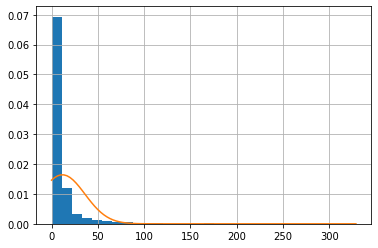

In [102]:
mv.hist(bins=30, density=True)
plt.plot(x, auxmodel.pdf(x))

(-1, 100)

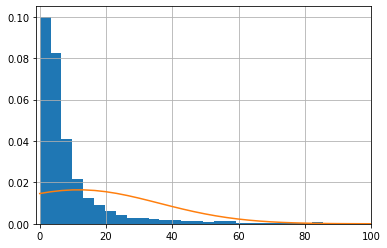

In [105]:
mv.hist(bins=100, density=True)
plt.plot(x, auxmodel.pdf(x))
plt.xlim(-1, 100)

In [100]:
auxmodel.cdf(0)

0.3145390510356489

### Improving upon a given model

Clearly a failure of the model above is that it gives a large weight to values < 0.

What would be the density with closest KL divergence to this Gaussian model subject to one additional constraint: that market value is never negative?

In [106]:
def f0(x):
    return x >= 0

In [107]:
features = [f0]

In [108]:
target_expectations = [f0(mv).mean()]        # P(X > 0) = 1

In [109]:
target_expectations

[1.0]

In [110]:
dist = stats.uniform(loc=mv.min()-1, scale=mv.max()-mv.min()+2)
sampler = auxiliary_sampler_scipy(dist, n=10**5)

In [111]:
# create a model
tweaked_model = maxentropy.MCMinDivergenceModel(features, sampler,
                                        prior_log_pdf=auxmodel.logpdf,
                                        vectorized=True)

In [112]:
X = np.reshape(target_expectations, (1, -1))
X.shape

(1, 1)

In [113]:
tweaked_model.fit(X)

MCMinDivergenceModel(algorithm='CG',
                     auxiliary_sampler=<function auxiliary_sampler_scipy.<locals>.sampler at 0x1a24b8ed08>,
                     feature_functions=None, matrix_format='csc_matrix',
                     prior_log_pdf=<bound method rv_frozen.logpdf of <scipy.stats._distn_infrastructure.rv_frozen object at 0x1a24e757b8>>,
                     vectorized=None, verbose=0)

In [114]:
tweaked_model.expectations()

array([0.99999998])

In [118]:
x = np.linspace(mv.min()-10, mv.max()+1, num=1000)

In [119]:
pdf = tweaked_model.pdf(tweaked_model.features(x),
                        log_prior_x=auxmodel.logpdf(x))

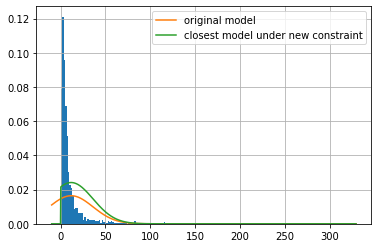

In [127]:
mv.hist(bins=200, density=True)
plt.plot(x, auxmodel.pdf(x), label='original model')
plt.plot(x, pdf, label='closest model under new constraint')
plt.legend();

### Improving upon a given model

Clearly a failure of the model above is that it doesn't give enough weight to values close to zero.

What would be the density with closest KL divergence to this Gaussian model subject to one additional constraint: the probability that the mv are between -2 and 2 (billion USD) is the same as that in the sample?

In [129]:
def f1(x):
    return (x > -2) & (x < 2)

In [130]:
features = [f0, f1]

In [131]:
target_expectations = [f0(mv).mean(), f1(mv).mean()]        # P(X > 0) = 1

In [133]:
target_expectations

[1.0, 0.16022380467955238]

In [135]:
# create a model
tweaked_model = maxentropy.MCMinDivergenceModel(features, sampler,
                                        prior_log_pdf=auxmodel.logpdf,
                                        vectorized=True)

In [136]:
X = np.reshape(target_expectations, (1, -1))
X.shape

(1, 2)

In [137]:
tweaked_model.fit(X)

MCMinDivergenceModel(algorithm='CG',
                     auxiliary_sampler=<function auxiliary_sampler_scipy.<locals>.sampler at 0x1a22d99a60>,
                     feature_functions=None, matrix_format='csc_matrix',
                     prior_log_pdf=<bound method rv_frozen.logpdf of <scipy.stats._distn_infrastructure.rv_frozen object at 0x1a24e757b8>>,
                     vectorized=None, verbose=0)

In [138]:
tweaked_model.expectations()

array([0.99999999, 0.16022382])

In [139]:
pdf = tweaked_model.pdf(tweaked_model.features(x),
                        log_prior_x=auxmodel.logpdf(x))

(-50, 50)

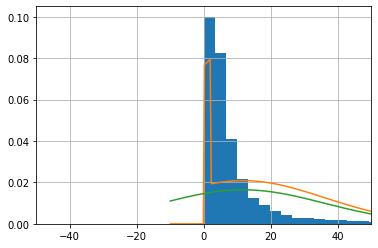

In [142]:
mv.hist(bins=100, density=True)
plt.plot(x, pdf)
plt.plot(x, auxmodel.pdf(x))
plt.xlim(-50, 50)

### Experiment: Constraining the mean

If we constrain the mean to be the same as the mean in the sample:

In [143]:
def f1(x):
    return x

In [145]:
features = [f0, f1]

In [146]:
target_expectations = [f0(mv).mean(), f1(mv).mean()]        # P(X > 0) = 1

In [147]:
target_expectations

[1.0, 11.735549338758902]

In [148]:
# create a model
tweaked_model = maxentropy.MCMinDivergenceModel(features, sampler,
                                        prior_log_pdf=auxmodel.logpdf,
                                        vectorized=True)

In [149]:
X = np.reshape(target_expectations, (1, -1))
X.shape

(1, 2)

In [150]:
tweaked_model.fit(X)

MCMinDivergenceModel(algorithm='CG',
                     auxiliary_sampler=<function auxiliary_sampler_scipy.<locals>.sampler at 0x1a22d99a60>,
                     feature_functions=None, matrix_format='csc_matrix',
                     prior_log_pdf=<bound method rv_frozen.logpdf of <scipy.stats._distn_infrastructure.rv_frozen object at 0x1a24e757b8>>,
                     vectorized=None, verbose=0)

In [151]:
tweaked_model.expectations()

array([ 1.        , 11.73554937])

In [152]:
pdf = tweaked_model.pdf(tweaked_model.features(x),
                        log_prior_x=auxmodel.logpdf(x))

(-50, 50)

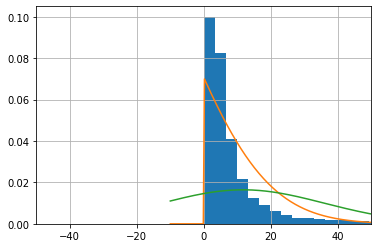

In [153]:
mv.hist(bins=100, density=True)
plt.plot(x, pdf)
plt.plot(x, auxmodel.pdf(x))
plt.xlim(-50, 50)

This is the closest model to starting model (in a KL divergence sense) that satisfies additional constraints in the form of linear expectation constraints.